In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from random import randint
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

## Enabling the GPU usage for tensorflow

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
print('Amount of GPUs :', len(gpu_devices))
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

Amount of GPUs : 1


## Importing the datasets
To import the datasets, we need to follow along with the relative folder path.

In [3]:
# Importing train dataset
train_data = pd.read_csv('datasets/kdd19/kddtrain.csv')
# Importing test dataset
test_data = pd.read_csv('datasets/kdd19/kddtest.csv')

## Importing columns to the datasets
Original NSL-KDD datasets do not contain any columns name. Therefore, we need to add the names of the columns.

In [4]:
train_data.columns = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]
test_data.columns = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]

## Pre-analysising how many data is contained
- Train dataframe contains the 43 columns which means there are 43 different categories of data fragments. For the data amount, it contains over 125972 rows. Therefore, it contain 125972 data tranfers.
- Columns of the test dataframe is the same as train dataframe but test dataframe contains data tranfers fewer than train datafram, 22542 rows.

In [5]:
pd.set_option("display.max_columns", None)
# train_data.head(3)
test_data.head(3)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.0,0.0,1.0,1.0,0.01,0.06,0.0,255,1,0.00,0.06,0.00,0.00,0.0,0.0,1.0,1.0,neptune,21
1,2,tcp,ftp_data,SF,12983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.0,134,86,0.61,0.04,0.61,0.02,0.0,0.0,0.0,0.0,normal,21
2,0,icmp,eco_i,SF,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65,0.0,0.0,0.0,0.0,1.00,0.00,1.0,3,57,1.00,0.00,1.00,0.28,0.0,0.0,0.0,0.0,saint,15


In [6]:
train_data.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag
count,125972.000000,1.259720e+05,1.259720e+05,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.0,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000
mean,287.146929,4.556710e+04,1.977927e+04,0.000198,0.022688,0.000111,0.204411,0.001222,0.395739,0.279253,0.001342,0.001103,0.302194,0.012669,0.000413,0.004096,0.0,0.000008,0.009423,84.108207,27.738093,0.284487,0.282488,0.119959,0.121184,0.660925,0.063053,0.097322,182.149200,115.653725,0.521244,0.082952,0.148379,0.032543,0.284455,0.278487,0.118832,0.120241,19.504056
std,2604.525522,5.870354e+06,4.021285e+06,0.014086,0.253531,0.014366,2.149977,0.045239,0.489011,23.942137,0.036603,0.045155,24.399715,0.483937,0.022181,0.099370,0.0,0.002817,0.096613,114.508828,72.636092,0.446457,0.447024,0.320437,0.323648,0.439624,0.180315,0.259831,99.206565,110.702886,0.448950,0.188922,0.308998,0.112564,0.444785,0.445670,0.306559,0.319460,2.291512
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.000000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,143.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,21.000000
max,42908.000000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,1.000000,2.000000,7468.000000,43.000000,2.000000,9.000000,0.0,1.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


In [7]:
# dropping the attack columns for TEST DATA
test_data.drop(['attack'], axis = 1, inplace = True)

test_data.head(3)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag
0,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.0,0.0,1.0,1.0,0.01,0.06,0.0,255,1,0.00,0.06,0.00,0.00,0.0,0.0,1.0,1.0,21
1,2,tcp,ftp_data,SF,12983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.0,134,86,0.61,0.04,0.61,0.02,0.0,0.0,0.0,0.0,21
2,0,icmp,eco_i,SF,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65,0.0,0.0,0.0,0.0,1.00,0.00,1.0,3,57,1.00,0.00,1.00,0.28,0.0,0.0,0.0,0.0,15


## Checking dirty data for both datasets
In this steps, we will check the dirty datasets and check what kind of data types are containing in the dataframes.info() function also shows how many memory usage is took in RAM.

In [8]:
# For train data
print('If True, it contains nulls: '+ str(train_data.isnull().values.any())) # this is checking entire dataframe
#train_data.isnull().sum() # if there is NaN, check the sum of NaN
print(train_data.info())

If True, it contains nulls: False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125972 entries, 0 to 125971
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125972 non-null  int64  
 1   protocol_type                125972 non-null  object 
 2   service                      125972 non-null  object 
 3   flag                         125972 non-null  object 
 4   src_bytes                    125972 non-null  int64  
 5   dst_bytes                    125972 non-null  int64  
 6   land                         125972 non-null  int64  
 7   wrong_fragment               125972 non-null  int64  
 8   urgent                       125972 non-null  int64  
 9   hot                          125972 non-null  int64  
 10  num_failed_logins            125972 non-null  int64  
 11  logged_in                    125972 non-null  int64  
 12  num_compromised         

In [9]:
# For test data
print('If True, it contains nulls: '+ str(test_data.isnull().values.any())) # this is checking entire dataframe
#test_data.isnull().sum() # if there is NaN, check the sum of NaN
print(test_data.info())

If True, it contains nulls: False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22542 entries, 0 to 22541
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     22542 non-null  int64  
 1   protocol_type                22542 non-null  object 
 2   service                      22542 non-null  object 
 3   flag                         22542 non-null  object 
 4   src_bytes                    22542 non-null  int64  
 5   dst_bytes                    22542 non-null  int64  
 6   land                         22542 non-null  int64  
 7   wrong_fragment               22542 non-null  int64  
 8   urgent                       22542 non-null  int64  
 9   hot                          22542 non-null  int64  
 10  num_failed_logins            22542 non-null  int64  
 11  logged_in                    22542 non-null  int64  
 12  num_compromised              22542 non-n

## Data Preprocessing
After checking the dirty, we will continue data preprocessing to fit in the model of neural network without having any troubles.

### Data Preprocessing for the object data
In this step, we will going to change different types of attack columns to just normal and irregular. <br>
First of all, we need to mapping the attack types to which is irregular or nomral.

In [10]:
train_data['attack'].unique()
map_attacks = {'ipsweep': 'irregular','satan': 'irregular','nmap': 'irregular','portsweep': 'irregular','saint': 'irregular',
'mscan': 'irregular','teardrop': 'irregular','pod': 'irregular','land': 'irregular','back': 'irregular','neptune': 'irregular',
'smurf': 'irregular','mailbomb': 'irregular','udpstorm': 'irregular','apache2': 'irregular','processtable': 'irregular',
'perl': 'irregular','loadmodule': 'irregular','rootkit': 'irregular','buffer_overflow': 'irregular','xterm': 'irregular',
'ps': 'irregular','sqlattack': 'irregular','httptunnel': 'irregular','ftp_write': 'irregular','phf': 'irregular',
'guess_passwd': 'irregular','warezmaster': 'irregular','warezclient': 'irregular','imap': 'irregular','spy': 'irregular',
'multihop': 'irregular','named': 'irregular','snmpguess': 'irregular','worm': 'irregular','snmpgetattack': 'irregular',
'xsnoop': 'irregular','xlock': 'irregular','sendmail': 'irregular','normal': 'normal'}

In [11]:
# adding and renaming the attack columns to traffic and apply data
# For TRAIN DATA
train_data['traffic'] = train_data['attack'].apply(lambda v: map_attacks[v])

# Predisplay data
train_data.head(3)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag,traffic
0,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.0,255,1,0.0,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15,normal
1,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.0,255,26,0.1,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19,irregular
2,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.0,30,255,1.0,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21,normal


In [12]:
test_data.head(3)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag
0,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.0,0.0,1.0,1.0,0.01,0.06,0.0,255,1,0.00,0.06,0.00,0.00,0.0,0.0,1.0,1.0,21
1,2,tcp,ftp_data,SF,12983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.0,134,86,0.61,0.04,0.61,0.02,0.0,0.0,0.0,0.0,21
2,0,icmp,eco_i,SF,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65,0.0,0.0,0.0,0.0,1.00,0.00,1.0,3,57,1.00,0.00,1.00,0.28,0.0,0.0,0.0,0.0,15


Dropout the unecessary column "attack" because there was new field 'traffic'

In [13]:
# For TRAIN DATA
train_data.drop(['attack'], axis=1, inplace=True)

In [14]:
# display attack modified data
train_data.head(3)
# print(test_data.head(3))

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag,traffic
0,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.0,255,1,0.0,0.60,0.88,0.00,0.00,0.00,0.0,0.00,15,normal
1,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.0,255,26,0.1,0.05,0.00,0.00,1.00,1.00,0.0,0.00,19,irregular
2,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.0,30,255,1.0,0.00,0.03,0.04,0.03,0.01,0.0,0.01,21,normal


In [15]:
train_data.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag
count,125972.000000,1.259720e+05,1.259720e+05,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.0,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000
mean,287.146929,4.556710e+04,1.977927e+04,0.000198,0.022688,0.000111,0.204411,0.001222,0.395739,0.279253,0.001342,0.001103,0.302194,0.012669,0.000413,0.004096,0.0,0.000008,0.009423,84.108207,27.738093,0.284487,0.282488,0.119959,0.121184,0.660925,0.063053,0.097322,182.149200,115.653725,0.521244,0.082952,0.148379,0.032543,0.284455,0.278487,0.118832,0.120241,19.504056
std,2604.525522,5.870354e+06,4.021285e+06,0.014086,0.253531,0.014366,2.149977,0.045239,0.489011,23.942137,0.036603,0.045155,24.399715,0.483937,0.022181,0.099370,0.0,0.002817,0.096613,114.508828,72.636092,0.446457,0.447024,0.320437,0.323648,0.439624,0.180315,0.259831,99.206565,110.702886,0.448950,0.188922,0.308998,0.112564,0.444785,0.445670,0.306559,0.319460,2.291512
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.000000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,143.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,21.000000
max,42908.000000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,1.000000,2.000000,7468.000000,43.000000,2.000000,9.000000,0.0,1.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


In [16]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125972 entries, 0 to 125971
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125972 non-null  int64  
 1   protocol_type                125972 non-null  object 
 2   service                      125972 non-null  object 
 3   flag                         125972 non-null  object 
 4   src_bytes                    125972 non-null  int64  
 5   dst_bytes                    125972 non-null  int64  
 6   land                         125972 non-null  int64  
 7   wrong_fragment               125972 non-null  int64  
 8   urgent                       125972 non-null  int64  
 9   hot                          125972 non-null  int64  
 10  num_failed_logins            125972 non-null  int64  
 11  logged_in                    125972 non-null  int64  
 12  num_compromised              125972 non-null  int64  
 13 

### Change and pop out traffic data into dataframe 

Now change the traffic object data to <b>normal = 0 and irregular =  1</b> values.

In [17]:
# map the traffic data
map_traffic = {'normal': 0,'irregular': 1}
train_data['traffic'] = train_data['traffic'].apply(lambda v: map_traffic[v])

In [18]:
train_data.head(3)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag,traffic
0,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.0,255,1,0.0,0.60,0.88,0.00,0.00,0.00,0.0,0.00,15,0
1,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.0,255,26,0.1,0.05,0.00,0.00,1.00,1.00,0.0,0.00,19,1
2,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.0,30,255,1.0,0.00,0.03,0.04,0.03,0.01,0.0,0.01,21,0


Now, pop out traffic field with a variable. <b>important!</b>

In [19]:
traffic_data = train_data.pop('traffic')

### Finding missing values in test data

In test datafram, some services data are missing ('harvest', 'http_2784', 'urh_i', 'tftp_u', 'aol', 'red_i', 'http_8001').

In [20]:
print("---------- For Train data ----------")
print("Protocol types are " + str(train_data['protocol_type'].unique()) + ". And total: " + str(train_data['protocol_type'].nunique()))
print("Services are " + str(train_data['service'].unique()) + ". And total: " + str(train_data['service'].nunique()))
print("Flags are " + str(train_data['flag'].unique()) + ". And total: " + str(train_data['flag'].nunique()))
print()
print("---------- For Test data ----------")
print("Protocol types are " + str(test_data['protocol_type'].unique()) + ". And total: " + str(test_data['protocol_type'].nunique()))
print("Services are " + str(test_data['service'].unique()) + ". And total: " + str(test_data['service'].nunique()))
print("Flags are " + str(test_data['flag'].unique()) + ". And total: " + str(test_data['flag'].nunique()))

---------- For Train data ----------
Protocol types are ['udp' 'tcp' 'icmp']. And total: 3
Services are ['other' 'private' 'http' 'remote_job' 'ftp_data' 'name' 'netbios_ns'
 'eco_i' 'mtp' 'telnet' 'finger' 'domain_u' 'supdup' 'uucp_path' 'Z39_50'
 'smtp' 'csnet_ns' 'uucp' 'netbios_dgm' 'urp_i' 'auth' 'domain' 'ftp'
 'bgp' 'ldap' 'ecr_i' 'gopher' 'vmnet' 'systat' 'http_443' 'efs' 'whois'
 'imap4' 'iso_tsap' 'echo' 'klogin' 'link' 'sunrpc' 'login' 'kshell'
 'sql_net' 'time' 'hostnames' 'exec' 'ntp_u' 'discard' 'nntp' 'courier'
 'ctf' 'ssh' 'daytime' 'shell' 'netstat' 'pop_3' 'nnsp' 'IRC' 'pop_2'
 'printer' 'tim_i' 'pm_dump' 'red_i' 'netbios_ssn' 'rje' 'X11' 'urh_i'
 'http_8001' 'aol' 'http_2784' 'tftp_u' 'harvest']. And total: 70
Flags are ['SF' 'S0' 'REJ' 'RSTR' 'SH' 'RSTO' 'S1' 'RSTOS0' 'S3' 'S2' 'OTH']. And total: 11

---------- For Test data ----------
Protocol types are ['tcp' 'icmp' 'udp']. And total: 3
Services are ['private' 'ftp_data' 'eco_i' 'telnet' 'http' 'smtp' 'ftp' 'ldap'

In [21]:
train_service = train_data['service'].tolist()
test_service = test_data['service'].tolist()
difference=list(set(train_service) - set(test_service))
print("They are services that needs to add after scaling object data " + str(difference))

They are services that needs to add after scaling object data ['http_2784', 'urh_i', 'http_8001', 'red_i', 'harvest', 'tftp_u', 'aol']


### Changing Numerical and Object Data
The numerical values and object data are changed simultaneously. <br>
Numerical values are scaled with StandardScaler and Object data are scaled with get_dummies.

In [22]:
# importing standard scaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler
standard_scaler = StandardScaler()

# extracting numerical value from dataframe
num_cols_train = train_data.select_dtypes(include=['float64','int64']).columns
num_cols_test = test_data.select_dtypes(include=['float64','int64']).columns

# extracting object value from dataframe
obj_cols_train = train_data.select_dtypes(include=['object']).copy()
obj_cols_test = test_data.select_dtypes(include=['object']).copy()

# scaling numeric data 
scaled_num_train = standard_scaler.fit_transform(train_data.select_dtypes(include=['float64','int64']))
scaled_num_test = standard_scaler.fit_transform(test_data.select_dtypes(include=['float64','int64']))

# scaling object data
dummy_obj_train = pd.get_dummies(obj_cols_train)
dummy_obj_test = pd.get_dummies(obj_cols_test)

# turn into dataframe
pd_scaled_num_train = pd.DataFrame(scaled_num_train, columns=num_cols_train)
pd_scaled_num_test = pd.DataFrame(scaled_num_test, columns=num_cols_test)

# print(obj_cols_train.shape)
# print(obj_cols_test.shape)

# merging both numeric data and object data
train_data = pd.concat([dummy_obj_train, pd_scaled_num_train], axis=1)
test_data = pd.concat([dummy_obj_test, pd_scaled_num_test], axis=1)

In [23]:
print(train_data.shape)
train_data.head(3)

(125972, 123)


,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.11025,-0.007737,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,-0.036652,-0.024437,-0.012385,-0.02618,-0.01861,-0.041221,0.0,-0.002818,-0.097531,-0.620987,-0.368112,-0.637213,-0.631933,-0.374364,-0.374433,-1.321420,0.482196,-0.374561,0.734337,-1.035693,-1.161035,2.736839,2.367729,-0.289105,-0.639535,-0.624874,-0.387635,-0.376389,-1.965547
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-0.11025,-0.007762,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,-0.036652,-0.024437,-0.012385,-0.02618,-0.01861,-0.041221,0.0,-0.002818,-0.097531,0.339641,-0.299275,1.602655,1.605095,-0.374364,-0.374433,-1.389660,0.038526,-0.374561,0.734337,-0.809862,-0.938292,-0.174419,-0.480194,-0.289105,1.608750,1.618946,-0.387635,-0.376389,-0.219968
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.11025,-0.007723,-0.002891,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,1.235686,-0.011664,-0.036652,-0.024437,-0.012385,-0.02618,-0.01861,-0.041221,0.0,-0.002818,-0.097531,-0.690851,-0.313042,-0.189239,-0.184527,-0.374364,-0.374433,0.771288,-0.349685,-0.374561,-1.533667,1.258746,1.066393,-0.439079,-0.383106,0.066249,-0.572087,-0.602436,-0.387635,-0.345086,0.652822


In [24]:
print(test_data.shape)
test_data.head(3)

(22542, 116)


,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_hostnames,service_http,service_http_443,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tim_i,service_time,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,-0.155541,-0.021989,-0.0969,-0.017625,-0.059107,-0.01946,-0.113526,-0.144005,-0.890443,-0.016494,-0.049456,-0.012638,-0.01426,-0.012912,-0.024022,-0.05232,0.0,-0.022096,-0.171079,0.443282,-0.338255,-0.348485,-0.347407,1.830265,1.837729,-1.770871,-0.131433,-0.386982,0.650134,-1.250339,-1.397343,-0.138291,-0.431809,-0.229991,-0.358135,-0.352767,1.979974,1.929264,0.698331
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.154120,0.005471,-0.0969,-0.017625,-0.059107,-0.01946,-0.113526,-0.144005,-0.890443,-0.016494,-0.049456,-0.012638,-0.01426,-0.012912,-0.024022,-0.05232,0.0,-0.022096,-0.171079,-0.606990,-0.338255,-0.348485,-0.347407,-0.573045,-0.565019,0.629389,-0.362976,-0.386982,-0.636607,-0.489913,0.002818,-0.228911,1.560020,0.004213,-0.358135,-0.352767,-0.602648,-0.565448,0.698331
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.155541,-0.021947,-0.0969,-0.017625,-0.059107,-0.01946,-0.113526,-0.144005,-0.890443,-0.016494,-0.049456,-0.012638,-0.01426,-0.012912,-0.024022,-0.05232,0.0,-0.022096,-0.171079,-0.606990,0.380328,-0.348485,-0.347407,-0.573045,-0.565019,0.629389,-0.362976,3.557025,-2.029691,-0.749353,0.898002,-0.410152,2.833484,3.048867,-0.358135,-0.352767,-0.602648,-0.565448,-0.706934


### Add 7 Missing service.
Therefore, we need to add the missing services.

In [25]:
# looping data and added missing service data to test dataset.
label_service = 'service_'
missing = [label_service + x for x in difference] # call difference from above
for col in missing:
    test_data[col] = 0


In [26]:
print(train_data.shape)
train_data.head(3)

(125972, 123)


,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.11025,-0.007737,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,-0.036652,-0.024437,-0.012385,-0.02618,-0.01861,-0.041221,0.0,-0.002818,-0.097531,-0.620987,-0.368112,-0.637213,-0.631933,-0.374364,-0.374433,-1.321420,0.482196,-0.374561,0.734337,-1.035693,-1.161035,2.736839,2.367729,-0.289105,-0.639535,-0.624874,-0.387635,-0.376389,-1.965547
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-0.11025,-0.007762,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,-0.036652,-0.024437,-0.012385,-0.02618,-0.01861,-0.041221,0.0,-0.002818,-0.097531,0.339641,-0.299275,1.602655,1.605095,-0.374364,-0.374433,-1.389660,0.038526,-0.374561,0.734337,-0.809862,-0.938292,-0.174419,-0.480194,-0.289105,1.608750,1.618946,-0.387635,-0.376389,-0.219968
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.11025,-0.007723,-0.002891,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,1.235686,-0.011664,-0.036652,-0.024437,-0.012385,-0.02618,-0.01861,-0.041221,0.0,-0.002818,-0.097531,-0.690851,-0.313042,-0.189239,-0.184527,-0.374364,-0.374433,0.771288,-0.349685,-0.374561,-1.533667,1.258746,1.066393,-0.439079,-0.383106,0.066249,-0.572087,-0.602436,-0.387635,-0.345086,0.652822


Check the indexes of service_http_2784,service_urh_i, service_http_8001, service_red_i, service_harvest, service_tftp_u, service_aol

In [69]:
# find the columns indexes to change the position the missing value
label_service = 'service_'
service_index = [label_service + x for x in difference] 
for i in service_index:
    num = train_data.columns.get_loc(i)
    print(f"Index of {i} column in given dataframe is : {num}")

Index of service_http_2784 column in given dataframe is : 28
Index of service_urh_i column in given dataframe is : 67
Index of service_http_8001 column in given dataframe is : 30
Index of service_red_i column in given dataframe is : 53
Index of service_harvest column in given dataframe is : 25
Index of service_tftp_u column in given dataframe is : 64
Index of service_aol column in given dataframe is : 6


In [27]:
print(test_data.shape)
test_data.head(3)

(22542, 123)


,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_hostnames,service_http,service_http_443,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tim_i,service_time,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag,service_http_2784,service_urh_i,service_http_8001,service_red_i,service_harvest,service_tftp_u,service_aol
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,-0.155541,-0.021989,-0.0969,-0.017625,-0.059107,-0.01946,-0.113526,-0.144005,-0.890443,-0.016494,-0.049456,-0.012638,-0.01426,-0.012912,-0.024022,-0.05232,0.0,-0.022096,-0.171079,0.443282,-0.338255,-0.348485,-0.347407,1.830265,1.837729,-1.770871,-0.131433,-0.386982,0.650134,-1.250339,-1.397343,-0.138291,-0.431809,-0.229991,-0.358135,-0.352767,1.979974,1.929264,0.698331,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.154120,0.005471,-0.0969,-0.017625,-0.059107,-0.01946,-0.113526,-0.144005,-0.890443,-0.016494,-0.049456,-0.012638,-0.01426,-0.012912,-0.024022,-0.05232,0.0,-0.022096,-0.171079,-0.606990,-0.338255,-0.348485,-0.347407,-0.573045,-0.565019,0.629389,-0.362976,-0.386982,-0.636607,-0.489913,0.002818,-0.228911,1.560020,0.004213,-0.358135,-0.352767,-0.602648,-0.565448,0.698331,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.155541,-0.021947,-0.0969,-0.017625,-0.059107,-0.01946,-0.113526,-0.144005,-0.890443,-0.016494,-0.049456,-0.012638,-0.01426,-0.012912,-0.024022,-0.05232,0.0,-0.022096,-0.171079,-0.606990,0.380328,-0.348485,-0.347407,-0.573045,-0.565019,0.629389,-0.362976,3.557025,-2.029691,-0.749353,0.898002,-0.410152,2.833484,3.048867,-0.358135,-0.352767,-0.602648,-0.565448,-0.706934,0,0,0,0,0,0,0


## Move missing value to correct position in here!

### Add final traffic field to train data.

In [28]:
# insert traffic to last column in train dataset
train_data.insert(123, 'traffic', traffic_data)

## Displaying both final datasets

In [29]:
print(train_data.shape)
train_data.head(3)

(125972, 124)


,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag,traffic
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.11025,-0.007737,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,-0.036652,-0.024437,-0.012385,-0.02618,-0.01861,-0.041221,0.0,-0.002818,-0.097531,-0.620987,-0.368112,-0.637213,-0.631933,-0.374364,-0.374433,-1.321420,0.482196,-0.374561,0.734337,-1.035693,-1.161035,2.736839,2.367729,-0.289105,-0.639535,-0.624874,-0.387635,-0.376389,-1.965547,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-0.11025,-0.007762,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,-0.036652,-0.024437,-0.012385,-0.02618,-0.01861,-0.041221,0.0,-0.002818,-0.097531,0.339641,-0.299275,1.602655,1.605095,-0.374364,-0.374433,-1.389660,0.038526,-0.374561,0.734337,-0.809862,-0.938292,-0.174419,-0.480194,-0.289105,1.608750,1.618946,-0.387635,-0.376389,-0.219968,1
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.11025,-0.007723,-0.002891,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,1.235686,-0.011664,-0.036652,-0.024437,-0.012385,-0.02618,-0.01861,-0.041221,0.0,-0.002818,-0.097531,-0.690851,-0.313042,-0.189239,-0.184527,-0.374364,-0.374433,0.771288,-0.349685,-0.374561,-1.533667,1.258746,1.066393,-0.439079,-0.383106,0.066249,-0.572087,-0.602436,-0.387635,-0.345086,0.652822,0


In [30]:
print(test_data.shape)
test_data.head(3)

(22542, 123)


,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_hostnames,service_http,service_http_443,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tim_i,service_time,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag,service_http_2784,service_urh_i,service_http_8001,service_red_i,service_harvest,service_tftp_u,service_aol
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,-0.155541,-0.021989,-0.0969,-0.017625,-0.059107,-0.01946,-0.113526,-0.144005,-0.890443,-0.016494,-0.049456,-0.012638,-0.01426,-0.012912,-0.024022,-0.05232,0.0,-0.022096,-0.171079,0.443282,-0.338255,-0.348485,-0.347407,1.830265,1.837729,-1.770871,-0.131433,-0.386982,0.650134,-1.250339,-1.397343,-0.138291,-0.431809,-0.229991,-0.358135,-0.352767,1.979974,1.929264,0.698331,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.154120,0.005471,-0.0969,-0.017625,-0.059107,-0.01946,-0.113526,-0.144005,-0.890443,-0.016494,-0.049456,-0.012638,-0.01426,-0.012912,-0.024022,-0.05232,0.0,-0.022096,-0.171079,-0.606990,-0.338255,-0.348485,-0.347407,-0.573045,-0.565019,0.629389,-0.362976,-0.386982,-0.636607,-0.489913,0.002818,-0.228911,1.560020,0.004213,-0.358135,-0.352767,-0.602648,-0.565448,0.698331,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.155541,-0.021947,-0.0969,-0.017625,-0.059107,-0.01946,-0.113526,-0.144005,-0.890443,-0.016494,-0.049456,-0.012638,-0.01426,-0.012912,-0.024022,-0.05232,0.0,-0.022096,-0.171079,-0.606990,0.380328,-0.348485,-0.347407,-0.573045,-0.565019,0.629389,-0.362976,3.557025,-2.029691,-0.749353,0.898002,-0.410152,2.833484,3.048867,-0.358135,-0.352767,-0.602648,-0.565448,-0.706934,0,0,0,0,0,0,0


### Cleaning unecessary columns 
num_outbound_cmds are all 0 data in both train and test data. Therefore, drop out all the data of num_outbound_cmds

In [31]:
# print(train_data['num_outbound_cmds'].value_counts())
# print(test_data['num_outbound_cmds'].value_counts())
# train_data.shape
test_data.shape

(22542, 123)

In [32]:
train_data.drop(['num_outbound_cmds'], axis=1, inplace=True)
test_data.drop(['num_outbound_cmds'], axis=1, inplace=True)

## Displaying SNS Heatmap Correlation 

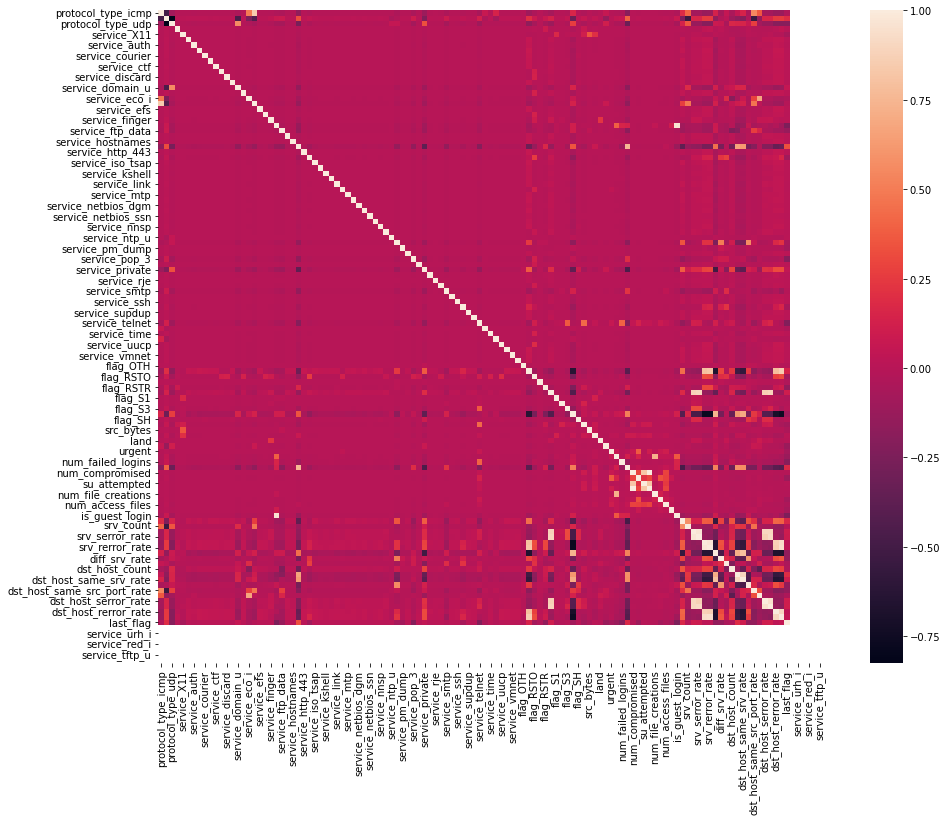

In [33]:
# correlation
corr = test_data.corr()
plt.figure(figsize=(15,12))
sns.heatmap(corr)
plt.show()

## Redisplay shape of both test and train data

In [34]:
print(train_data.shape)
print(test_data.shape)

(125972, 123)
(22542, 122)


## Modeling for machine learning

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [57]:
# target = train_data[['traffic']]
# X_train = train_data.drop(['traffic',], axis=1)

# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state =42)
# print(X_train.shape, X_test.shape)
# print(Y_train.shape, Y_test.shape)
# X_train = X_train , Y_train = target, X_test = test_data, Y_test = target

In [58]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB

In [51]:
GNbayes = GaussianNB()

In [59]:
import time
start_time = time.time()
GNbayes.fit(X_train, target.values.ravel())
end_time = time.time()

In [60]:
print("Training time: ",end_time-start_time)

Training time:  0.3553612232208252


In [63]:
start_time = time.time()
Y_test_pred1 = GNbayes.predict(test_data)
end_time = time.time()
print("Testing time: ",end_time-start_time)

Testing time:  0.0608370304107666


D:\python 3.9.5\lib\site-packages\sklearn\base.py:484: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [64]:
print("Train score is:", GNbayes.score(X_train, target))
print("Test score is:",GNbayes.score(test_data,target))

Train score is: 0.8591750547740767


D:\python 3.9.5\lib\site-packages\sklearn\base.py:484: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


ValueError: Found input variables with inconsistent numbers of samples: [125972, 22542]